In [127]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import random
import pandas as pd
import cv2
import dlib

In [128]:
list_attr=pd.read_csv("list_attr_celeba.txt" , sep=r"\s+", header = 0)
print(list_attr.iloc[0].to_frame().T)

            5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
000001.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
000001.jpg    -1     -1        -1        -1          -1          -1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
000001.jpg         -1        1              1         -1                 1   

            Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
000001.jpg           -1                 1                -1               -1   

            Young  
000001.jpg      1  

[1 rows x 40 columns]


In [129]:
pos_attr=pd.read_csv("list_landmarks_align_celeba.txt" , sep=r"\s+", header = 0)
a = pos_attr.iloc[0].to_frame().T
print(a)
print(type(a))

            lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
000001.jpg         69        109         106         113      77     142   

            leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
000001.jpg           73          152           108           154  
<class 'pandas.core.frame.DataFrame'>


In [130]:
def plot_visage(face, ax=None):
    """Affiche le visage"""
    if ax is None:
        plt.imshow(face)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(face)
        ax.axis('off')

In [131]:
def align_face(img, landmarks_init, landmarks_fin, size=(256, 256)):
    """Aligne un visage en utilisant une transformation homographique basée sur les 68 landmarks."""
    if isinstance(img, Image.Image):
        img = np.array(img)
    init_points = np.float32(landmarks_init)
    fin_points = np.float32(landmarks_fin)
    matrix, _ = cv2.findHomography(init_points, fin_points)
    aligned_face = cv2.warpPerspective(img, matrix, size)
    return aligned_face


def condition_retourner(image1, image2):
    """Flip une des deux images si les visages sont tournés dans une direction différente."""
    position_landmarks_1 = [get_landmarks(image1)[position] for position in [30, 39, 42]]
    position_landmarks_2 = [get_landmarks(image2)[position] for position in [30, 39, 42]]
    
    centre1 = int((position_landmarks_1[1][0] + position_landmarks_1[2][0])/2)
    centre2 = int((position_landmarks_2[1][0] + position_landmarks_2[2][0])/2)

    delta = 5
    
    if ((centre1-position_landmarks_1[0][0]) < -delta and (centre2-position_landmarks_2[0][0]) > delta) or ((centre1-position_landmarks_1[0][0]) > delta and (centre2-position_landmarks_2[0][0]) < -delta):
        image2_retourne = retourner_visage(image2)
        return image1, image2_retourne
    return image1, image2


def retourner_visage(image):
    """Retourne une image selon un axe vertical."""
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    image_retourne = ImageOps.mirror(image)
    return image_retourne


def blend_faces(face1, face2, alpha=0.5):
    """Fusionne deux visages avec un mélange pondéré (taux alpha)."""
    face1, face2 = condition_retourner(face1, face2)
    landmarks1 = get_landmarks(face1)
    landmarks2 = get_landmarks(face2)

    if landmarks1 is None or landmarks2 is None:
        print("Erreur : Impossible de détecter les landmarks pour au moins un visage.")
        return None, None 
    #plot_visage(face2)
    avg_pos_attr = np.mean([landmarks1, landmarks2], axis=0).astype(int)

    aligned_face_1 = align_face(face1, landmarks1, avg_pos_attr)
    aligned_face_2 = align_face(face2, landmarks2, avg_pos_attr)

    blended_face = cv2.addWeighted(aligned_face_1, alpha, aligned_face_2, 1 - alpha, 0)
    blended_face_pil = Image.fromarray(blended_face)

    return blended_face_pil, avg_pos_attr

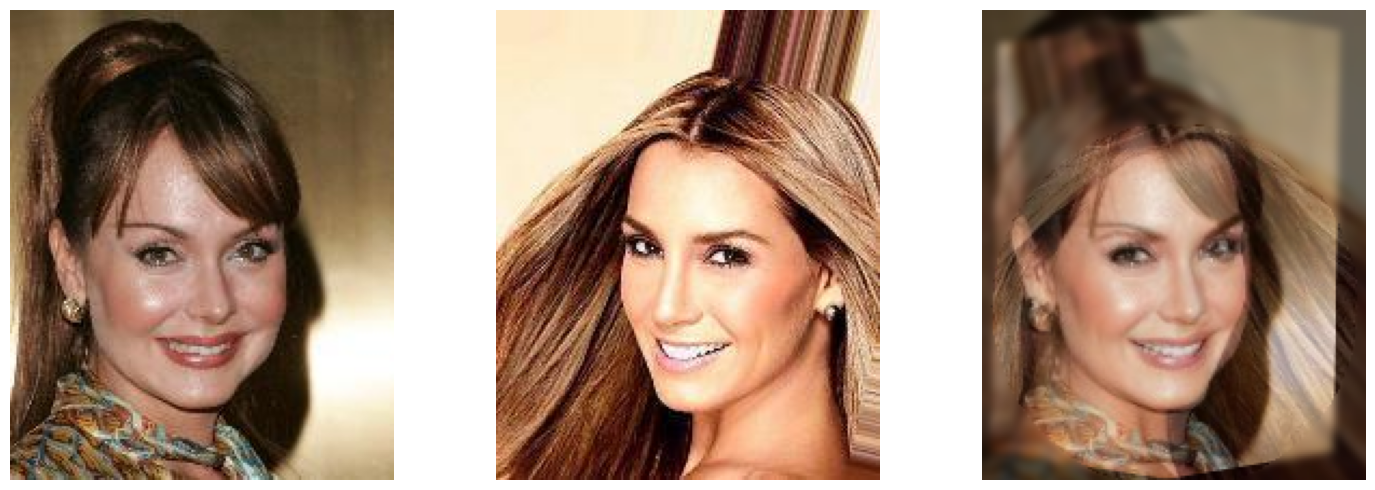

In [132]:
image_ = Image.open("img_align_celeba/000009.jpg")
#image_ = draw_landmarks(image_, [30, 39, 42])

image_1 = Image.open("img_align_celeba/000001.jpg")
#image_1 = draw_landmarks(image_1)

new_face = mix_main(image_, image_1, alpha=0.6)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_visage(image_, axes[0])
plot_visage(image_1, axes[1])
plot_visage(new_face, axes[2])
plt.tight_layout()
plt.show()

In [143]:
def get_landmarks(image):
    """Récupère les 68 points caractéristiques du visage grâce au modèle de dlib."""
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    image = np.array(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return ("Erreur : Je ne détecte pas de visage")
    landmarks = predictor(gray, faces[0])
    return np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in range(68)])


def draw_landmarks(image, which="all"):
    """Dessine les 68 points caractéristiques sur l'image."""
    image = np.array(image)
    landmarks = get_landmarks(image)
    #print(landmarks)
    if (which=="all"):
        for (x, y) in landmarks:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
        return image  
    which_landmarks = [landmarks[position] for position in which]
    for (x, y) in which_landmarks:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    return image     

In [134]:
def apply_blur_around_face(image, landmarks, blur_strength):
    """Applique un flou autour du visage en utilisant les landmarks."""
    image = np.array(image)
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    center = np.mean(landmarks, axis=0).astype(int)
    radius = int(np.max(np.linalg.norm(landmarks - center, axis=1))) + 20
    cv2.circle(mask, tuple(center), radius, (255), thickness=-1)

    blurred_image = cv2.GaussianBlur(image, (blur_strength, blur_strength), 0)
    masked_face = cv2.bitwise_and(image, image, mask=mask)
    blurred_background = cv2.bitwise_and(blurred_image, blurred_image, mask=255-mask)
    combined_image = cv2.add(masked_face, blurred_background)
    combined_image_pil = Image.fromarray(combined_image)

    return combined_image_pil

def crop(face):
    """Enlève les bordures noires."""
    if isinstance(face, np.ndarray):
        face = Image.fromarray(face)
    face = face.crop((0, 0, 178, 218))

    return face

In [135]:
def mix_main(face1, face2, alpha):
    blended_face = blend_faces(face1, face2, alpha)
    new_face = blended_face[0]
    new_face_attr = blended_face[1]
    new_face_floue = apply_blur_around_face(new_face, new_face_attr, blur_strength=11)

    new_face_floue_crop = crop(new_face_floue)
    #new_face_floue_crop = draw_landmarks(new_face_floue_crop)
    return new_face_floue_crop

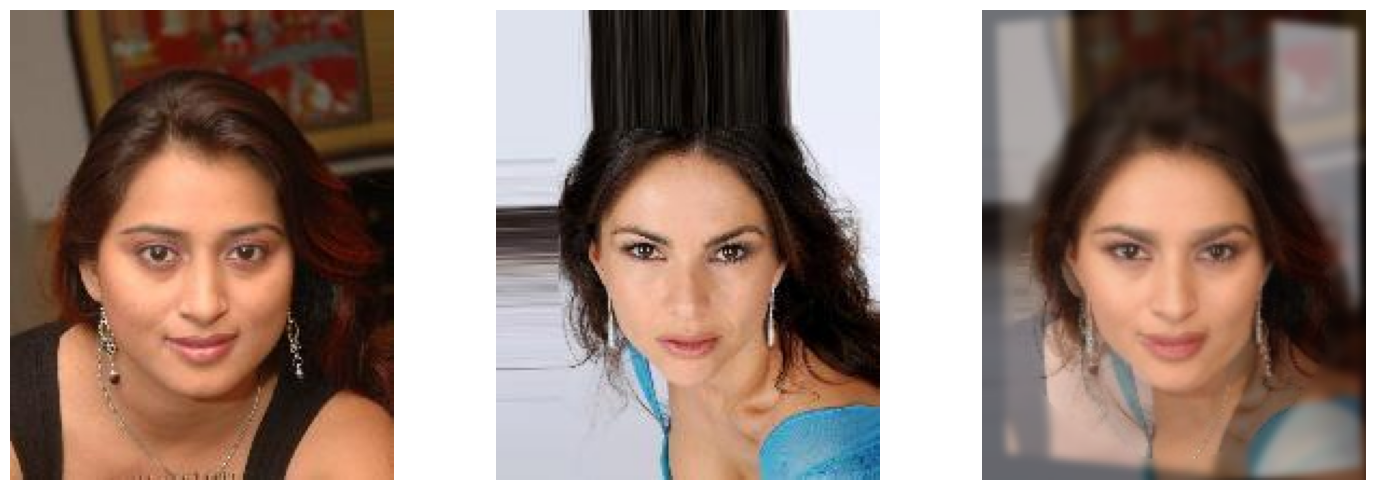

In [136]:
face1 = Image.open("img_align_celeba/000665.jpg")
face2 = Image.open("img_align_celeba/000550.jpg")
new_face = mix_main(face1, face2, alpha=0.5)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_visage(face1, axes[0])
plot_visage(face2, axes[1])
plot_visage(new_face, axes[2])
plt.tight_layout()
plt.show()

In [141]:
def modifier_landmarks(face, valeur, attribut="yeux", direction="centre"):
    """
    Modifie les landmarks :
    oeil gauche : 36-41
    oeil droit : 42-47
    bouche : 48-68
    nez : 27-35
    contour du visage : 0-16

    Renvoie le visage déformé.
    """
    landmarks = get_landmarks(face)
    new_landmarks = landmarks.copy()
    if attribut=="yeux":
        oeil_gauche = list(range(36, 42))
        oeil_droit = list(range(42, 48))
        if direction=="centre":
            new_landmarks[oeil_gauche] +=[valeur, 0]
            new_landmarks[oeil_droit] +=[-valeur, 0]
        if direction=="bord":
            new_landmarks[oeil_gauche] +=[-valeur, 0]
            new_landmarks[oeil_droit] +=[valeur, 0]
        if direction=="bas":
            new_landmarks[oeil_gauche] +=[0, -valeur]
            new_landmarks[oeil_droit] +=[0, -valeur]
        if direction=="haut":
            new_landmarks[oeil_gauche] +=[0, valeur]
            new_landmarks[oeil_droit] +=[0, valeur]
            
        return ajuster_visage(face, landmarks, new_landmarks)
        
    if attribut=="bouche":
        bouche = list(range(48, 68))
        if direction=="droite":
            new_landmarks[bouche] +=[valeur, 0]
        if direction=="gauche":
            new_landmarks[bouche] +=[-valeur, 0]
        if direction=="bas":
            new_landmarks[bouche] +=[0, valeur]
        if direction=="haut":
            new_landmarks[bouche] +=[0, -valeur]
        return ajuster_visage(face, landmarks, new_landmarks)
        
    if attribut=="nez":
        nez = list(range(27, 36))
        if direction=="droite":
            new_landmarks[nez] +=[valeur, 0]
        if direction=="gauche":
            new_landmarks[nez] +=[-valeur, 0]
        if direction=="bas":
            new_landmarks[nez] +=[0, valeur]
        if direction=="haut":
            new_landmarks[nez] +=[0, -valeur]
        return ajuster_visage(face, landmarks, new_landmarks)
    return 


def find_closest_landmark(landmarks, point):
    """Trouve le landmark le plus proche d'un point donné."""
    points = np.array(landmarks)
    point = np.array(point)
    distances = np.linalg.norm(points - point, axis=1)
    return np.argmin(distances)


def ajuster_visage(face, landmarks_init, landmarks_fin):
    """Applique une déformation locale avec interpolation triangulaire tout en conservant le reste de l'image."""
    if landmarks_init is None or landmarks_fin is None:
        print("Erreur : Impossible de réaliser l'ajustement du visage.")
        print("Il manque des landmarks.")
        return None

    if isinstance(face, Image.Image):
        face = np.array(face)
    
    h, w = face.shape[:2]
    rect = (0, 0, w, h)
    subdiv = cv2.Subdiv2D(rect)

    for lm in landmarks_init:
        subdiv.insert((float(lm[0]), float(lm[1])))  
    triangles = subdiv.getTriangleList().astype(int)
    masque_visage = np.zeros((h, w), dtype=np.uint8)
    new_face = np.zeros_like(face)

    for tri in triangles:
        x1, y1, x2, y2, x3, y3 = tri
        idx1 = find_closest_landmark(landmarks_init, (x1, y1))
        idx2 = find_closest_landmark(landmarks_init, (x2, y2))
        idx3 = find_closest_landmark(landmarks_init, (x3, y3))
        pts1 = np.array([landmarks_init[idx1], landmarks_init[idx2], landmarks_init[idx3]], np.float32)
        pts2 = np.array([landmarks_fin[idx1], landmarks_fin[idx2], landmarks_fin[idx3]], np.float32)

        M = cv2.getAffineTransform(pts1, pts2)
        warped_triangle = cv2.warpAffine(face, M, (w, h))
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32([pts2]), 255)
        masque_visage = cv2.bitwise_or(masque_visage, mask)
        new_face = cv2.bitwise_or(new_face, cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask))

    face_sans_visage = cv2.bitwise_and(face, face, mask=cv2.bitwise_not(masque_visage))
    image_finale = cv2.bitwise_or(face_sans_visage, new_face)

    return Image.fromarray(image_finale)


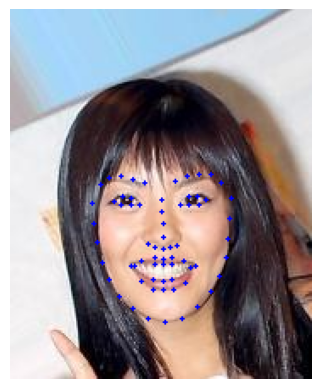

In [144]:
face = Image.open("img_align_celeba/000422.jpg")
face = draw_landmarks(face)
plot_visage(face)

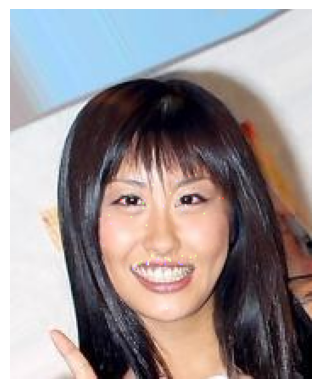

In [145]:
face = Image.open("img_align_celeba/000422.jpg")
new_face = modifier_landmarks(face, -3, attribut="yeux", direction="bord")
new_face = modifier_landmarks(new_face, 5, attribut="nez", direction="bas")
new_face = modifier_landmarks(new_face, 2, attribut="bouche", direction="bas")

#new_face = draw_landmarks(new_face)

plot_visage(new_face)